# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.display import display

import math
from sklearn.linear_model import LinearRegression

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4973,0,22.0,27200.0,0,0
4519,0,28.0,48400.0,1,0
4253,0,20.0,32000.0,2,0
1135,1,30.0,35300.0,1,0
650,0,26.0,49300.0,2,0
1874,1,41.0,40900.0,0,0
4706,1,33.0,32100.0,3,0
4224,0,34.0,46000.0,1,0
83,1,37.0,60900.0,2,0
3256,1,26.0,46800.0,2,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
df.shape

(5000, 5)

There are 5,000 rows and 5 columns.

In [7]:
# Fix the age type (from float to int)

df['age'] = df['age'].astype(int)
df['income'] = df['income'].astype(int)

In [8]:
# Check if the conversion was successful

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   gender              5000 non-null   int64
 1   age                 5000 non-null   int64
 2   income              5000 non-null   int64
 3   family_members      5000 non-null   int64
 4   insurance_benefits  5000 non-null   int64
dtypes: int64(5)
memory usage: 195.4 KB


Initital Descriptive Statistic of the data

In [9]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.359400,1.194200,0.148000
std,0.500049,8.440807,9900.082063,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


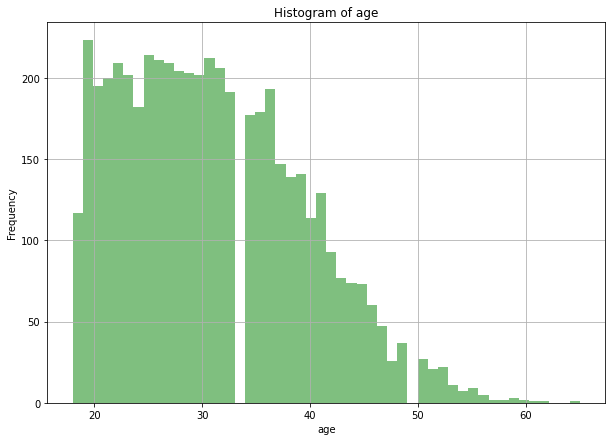

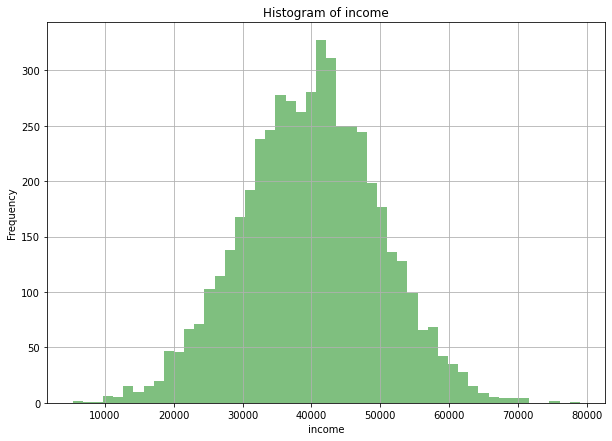

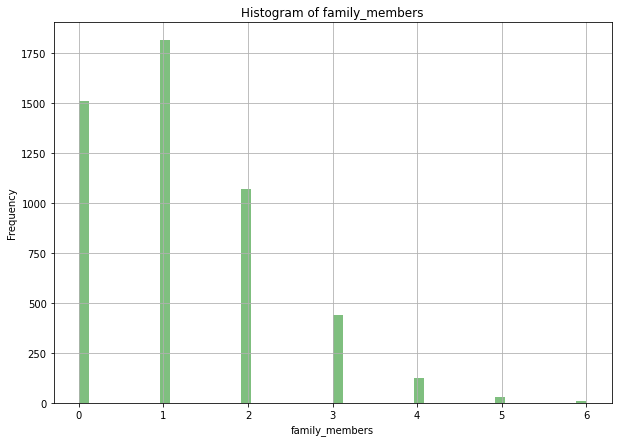

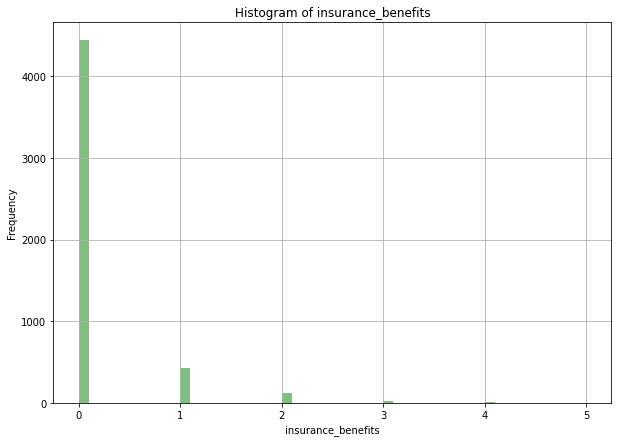

In [10]:
for column in df.columns:
    if column != 'gender':  # Exclude the 'gender' column
        plt.figure(figsize=(10, 7))
        plt.tight_layout()
        plt.hist(df[column], bins=50, alpha=0.5, color='g')
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

There is no anomality of the data from the initial descriptive statistics.

In [11]:
# Checking for missing values

df.isnull().any(axis=1).sum() 

0

There is no missing values.

In [12]:
# Checking for duplicates

num_duplicates = len(df[df.duplicated()])
total_rows = len(df)
percentage_duplicates = (num_duplicates / total_rows) * 100

print(f"The percentage of duplicates is: {percentage_duplicates:.2f}%")

The percentage of duplicates is: 3.06%


In [13]:
# Removing duplicates

df = df.drop_duplicates()

In [14]:
# Checking data after dropping duplicates

df.shape

(4847, 5)

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

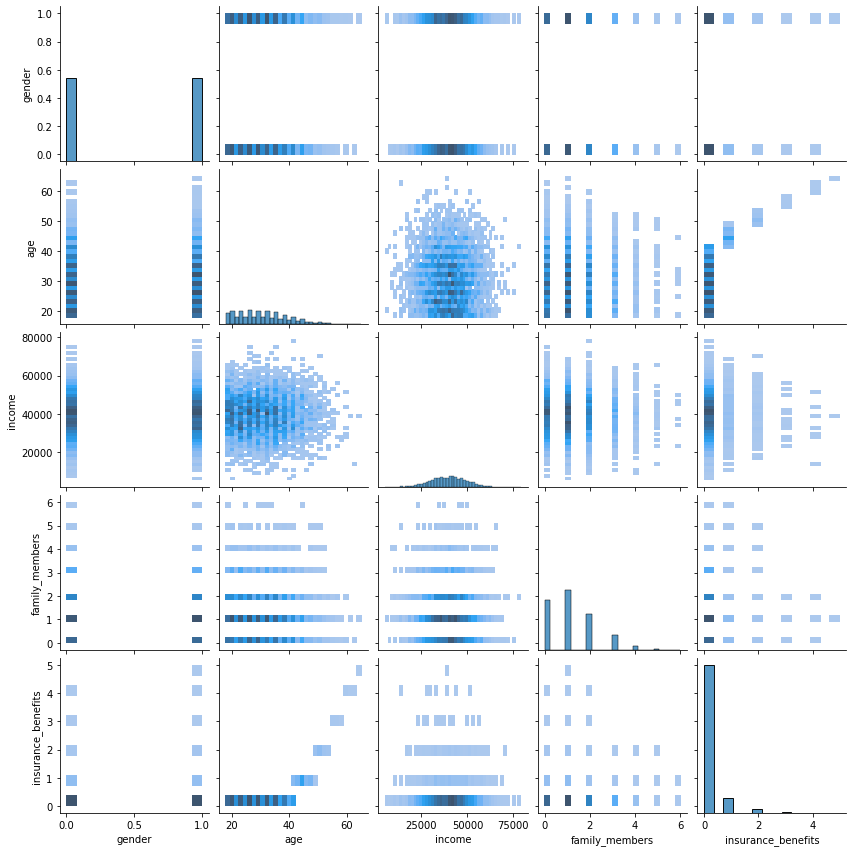

In [15]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [16]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [17]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
    
    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k, metric=metric, algorithm='brute')
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [18]:
# Unscaled data with searching nearest object from index# 1 using Euclidean distance:

knn_unscaled_euclidean = get_knn(df, n=1, k=5, metric='euclidean')
knn_unscaled_euclidean

,gender,age,income,family_members,insurance_benefits,distance
1,0.0,46.0,38000.0,1.0,1.0,0.000000
2480,NaN,NaN,NaN,NaN,NaN,10.099505
2528,1.0,36.0,38000.0,0.0,0.0,NaN
3498,NaN,NaN,NaN,NaN,NaN,13.038405
3593,0.0,33.0,38000.0,0.0,0.0,NaN
3810,NaN,NaN,NaN,NaN,NaN,6.082763
3920,0.0,40.0,38000.0,0.0,0.0,NaN
4796,NaN,NaN,NaN,NaN,NaN,9.055385
4948,1.0,37.0,38000.0,1.0,0.0,NaN


In [19]:
# Unscaled data with searching nearest object from index# 1 using Manhattan distance:

knn_unscaled_manhattan = get_knn(df, n=1, k=5, metric='manhattan')
knn_unscaled_manhattan

,gender,age,income,family_members,insurance_benefits,distance
1,0.0,46.0,38000.0,1.0,1.0,0.0
2480,NaN,NaN,NaN,NaN,NaN,12.0
2528,1.0,36.0,38000.0,0.0,0.0,NaN
3498,NaN,NaN,NaN,NaN,NaN,14.0
3593,0.0,33.0,38000.0,0.0,0.0,NaN
3810,NaN,NaN,NaN,NaN,NaN,7.0
3920,0.0,40.0,38000.0,0.0,0.0,NaN
4796,NaN,NaN,NaN,NaN,NaN,10.0
4948,1.0,37.0,38000.0,1.0,0.0,NaN


The results obtained using the Euclidean metric and the Manhattan metric showed not much differences.

**Scaling the data.**

In [20]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [21]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
163,0.0,0.476923,0.546835,0.500000,0
3344,1.0,0.846154,0.477215,0.166667,3
1854,1.0,0.292308,0.735443,0.166667,0
1143,1.0,0.769231,0.736709,0.000000,2
145,1.0,0.630769,0.420253,0.500000,0


Now, let's get similar records for a given one for every combination

In [22]:
# Scaled data with MaxAbsScaler and searching nearest object from index# 1 using Euclidean distance:

knn_scaled_euclidean = get_knn(df_scaled, n=1, k=5, metric='euclidean')
knn_scaled_euclidean

,gender,age,income,family_members,insurance_benefits,distance
1,0.0,0.707692,0.481013,0.166667,1.0,0.000000
1835,NaN,NaN,NaN,NaN,NaN,0.011392
1863,0.0,0.707692,0.492405,0.166667,1.0,NaN
4041,NaN,NaN,NaN,NaN,NaN,0.003797
4162,0.0,0.707692,0.477215,0.166667,1.0,NaN
4341,NaN,NaN,NaN,NaN,NaN,0.026453
4477,0.0,0.692308,0.459494,0.166667,1.0,NaN
4833,NaN,NaN,NaN,NaN,NaN,0.018418
4986,0.0,0.723077,0.491139,0.166667,1.0,NaN


In [23]:
# Scaled data with MaxAbsScaler and searching nearest object from index# 1 using Manhattan distance:

knn_scaled_manhattan = get_knn(df_scaled, n=1, k=5, metric='manhattan')
knn_scaled_manhattan

,gender,age,income,family_members,insurance_benefits,distance
1,0.0,0.707692,0.481013,0.166667,1.0,0.000000
1835,NaN,NaN,NaN,NaN,NaN,0.011392
1863,0.0,0.707692,0.492405,0.166667,1.0,NaN
2394,NaN,NaN,NaN,NaN,NaN,0.032035
2434,0.0,0.676923,0.482278,0.166667,1.0,NaN
4041,NaN,NaN,NaN,NaN,NaN,0.003797
4162,0.0,0.707692,0.477215,0.166667,1.0,NaN
4833,NaN,NaN,NaN,NaN,NaN,0.025511
4986,0.0,0.723077,0.491139,0.166667,1.0,NaN


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

1. In the unscaled data, the distances are directly related to the absolute differences in the feature values.

2. In the scaled data, all features are on similar scales (between 0 and 1), so each feature contributes more evenly to the distance calculation. This can lead to more accurate nearest neighbor selection.

3. For both scaled and unscaled data, we can observe that the nearest neighbors are slightly different under Euclidean and Manhattan distance metrics.

4. Euclidean distance considers the straight-line distance between points, while Manhattan distance calculates the distance by summing the absolute differences along each dimension. This can lead to different neighbor selections based on the metric used.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Comparing the Manhattan distance results (regardless of scaling), we can observe some similarities in the neighbors selected. There is a slight difference of the distance when using the Manhattan metric.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [24]:
# calculate the target

df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)

In [25]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts()

0    4284
1     563
Name: insurance_benefits_received, dtype: int64

**We can observe that there is imblance of the data from insurance_benefits_received. Data with value of 0 is 7.6x more than data with value of 1.**

In [26]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [27]:
X = df[feature_names]
y = df['insurance_benefits_received']

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [28]:
model1 = sklearn.neighbors.KNeighborsClassifier()
model1.fit(X_train, y_train)
predicted_test = model1.predict(X_test)

In [29]:
#Model evaluation without scaling
eval_classifier(y_test, predicted_test)

F1: 0.23
Confusion Matrix
[[0.87766323 0.00687285]
 [0.09965636 0.01580756]]


**Conclusion: We obtained the results for F1 score: 0.23 for the model evaluation without scaling (Supervised).**

In [30]:
scaler = sklearn.preprocessing.MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
model2 = sklearn.neighbors.KNeighborsClassifier()
model2.fit(X_train_scaled, y_train)
predicted_test_sc = model2.predict(X_test_scaled)

In [32]:
#Model evaluation with scaling
eval_classifier(y_test, predicted_test_sc)

F1: 0.90
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.01786942 0.0975945 ]]


**Conclusion: We obtained the results for F1 score: 0.90 for the model evaluation with scaling (Supervised). It is higher than the F1 score of the model without scaling.**

In [33]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [34]:
# Evaluate dummy model for different probabilities
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df)) 
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.88384568 0.        ]
 [0.11615432 0.        ]]

The probability: 0.12
F1: 0.13
Confusion Matrix
[[0.78502166 0.09882401]
 [0.1017124  0.01444192]]

The probability: 0.50
F1: 0.19
Confusion Matrix
[[0.44873117 0.4351145 ]
 [0.05921188 0.05694244]]

The probability: 1.00
F1: 0.21
Confusion Matrix
[[0.         0.88384568]
 [0.         0.11615432]]



Based on the dummy model above, we have tested it with four probability values. We get a probability with a value of "1" with an F1 score of 0.20 for the forth model.

In conclusion, the kNN classification model is better than the dummy model, because the kNN classification model has an F1 score 0.90 (after scaled) which has a significant gain from the previous F1 score (before scaled) which was only 0.23. Meanwhile, the dummy model only has an F1 score 0.21 with four tests and has no significant gain.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [35]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y # <your code here>

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1) # <your code here>
        y_pred = X2 @ self.weights # <your code here>
        
        return y_pred

In [36]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [37]:
X = df[feature_names].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.77366679e-01  1.95594897e-02  3.58042290e-02  5.85335011e-07
 -1.21618426e-02]
RMSE: 0.36
R2: 0.66


**Conclusion:**

The results from **MyLinearRegression** is as below:

RMSE: 0.36

R2: 0.66

In [38]:
lr_sklearn = LinearRegression()

In [39]:
lr_sklearn.fit(X_train, y_train)

y_test_pred_skl = lr_sklearn.predict(X_test)
eval_regressor(y_test, y_test_pred_skl)

RMSE: 0.36
R2: 0.66


**Conclusion:**

The results from **LinearRegression** is as below:

RMSE: 0.36

R2: 0.66

**Conclusion:**
Both MyLinearRegression & LinearRegression have the same results.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [40]:
df_pn = df[feature_names]

In [41]:
X = df_pn.to_numpy()

In [42]:
X

array([[    1,    41, 49600,     1],
       [    0,    46, 38000,     1],
       [    0,    29, 21000,     0],
       ...,
       [    0,    20, 33900,     2],
       [    1,    22, 32700,     3],
       [    1,    28, 40600,     1]])

Generating a random matrix $P$.

In [43]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [44]:
P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

Checking the matrix $P$ is invertible

In [45]:
# Calculate the determinant of P

P_inv = np.linalg.det(P)

if P_inv != 0:
    print("Matrix P is invertible.")
else:
    print("Matrix P is not invertible.")

Matrix P is invertible.


In [46]:
X_prime = X.dot(P)

In [47]:
X_prime

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

Can you guess the customers' ages or income after the transformation?

We could not guess the customers' ages or income after the transformation, those are big numbers.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

The error occurred when checking with calculations by moving  𝑃 from the right side of the formula above to the left one. 

In [48]:
# Assuming X_prime is the obfuscated data and P is the transformation matrix
(X.dot(P)).dot(P_inv)

array([[ 1547.89974942,  5447.19713102,  4484.26450205, 11196.17212745],
       [ 1186.11767001,  4176.68506915,  3438.09299028,  8580.38654459],
       [  655.4815137 ,  2308.90724823,  1900.6021333 ,  4742.44672792],
       ...,
       [ 1057.83323016,  3721.26922453,  3063.36324284,  7650.64447659],
       [ 1020.80605795,  3590.5071578 ,  2955.75180852,  7380.57225119],
       [ 1266.96600243,  4457.52976289,  3669.61487074,  9163.58563191]])

In [49]:
np.allclose(np.dot(P, np.linalg.inv(P)), np.dot(np.linalg.inv(P), P))

True

**Conclusions**:

Yes, we can recover the original data from X' if P is known.

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [50]:
# Origingal data
X

array([[    1,    41, 49600,     1],
       [    0,    46, 38000,     1],
       [    0,    29, 21000,     0],
       ...,
       [    0,    20, 33900,     2],
       [    1,    22, 32700,     3],
       [    1,    28, 40600,     1]])

In [51]:
# Transformed data
X.dot(P)

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

In [52]:
# Reversed data
(X.dot(P)).dot(P_inv)

array([[ 1547.89974942,  5447.19713102,  4484.26450205, 11196.17212745],
       [ 1186.11767001,  4176.68506915,  3438.09299028,  8580.38654459],
       [  655.4815137 ,  2308.90724823,  1900.6021333 ,  4742.44672792],
       ...,
       [ 1057.83323016,  3721.26922453,  3063.36324284,  7650.64447659],
       [ 1020.80605795,  3590.5071578 ,  2955.75180852,  7380.57225119],
       [ 1266.96600243,  4457.52976289,  3669.61487074,  9163.58563191]])

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

May be there is no random state when doing the transformation, so the numbers keep moving randomly.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

1. All values of X on W are scaled multiplication with the same matrix. So, it is the same magnitude as the transformation and must have the same value for all values of X.

2. It also means that the regression will be a linear transformation of the first equation and if so the relationship between the variables will be the same.

**Analytical proof**

Initial equation:
$$
w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

We can do the multiplication as such:
$$
w_P = [(XP)^T XP]^{-1} X^T P^T y
$$

Next we expand the components inside the square bracket:
$$
w_P = [X^T P^T XP]^{-1} X^T P^T y
$$

Next we expand further to remove the square bracket:
$$
w_P = (X^T X)^{-1} (P^T)^{-1} P^{-1} X^T P^T y
$$

We know that
$$
(P^T)^{-1} P^T = P^T (P^T)^{-1} = I
$$

NextThus the equation can be simplify as such:
$$
w_P = (X^T X)^{-1} P^{-1} I X^T y
$$

Known that:
$$
w = (X^T X)^{-1} X^T y
$$

By substituting $w$ into the equation:
$$
w_P = P^{-1} w
$$

We also know below formula
$$
y = X w
$$

Formula to calculate the predicted value:
$$
y P = X w P
$$

By substituting $wP$ from the above equation:
$$
y P = X P (P^{-1} w)
$$

By obfuscating the X variable, we have
$$
X = X P
$$

By substituting this equation in the above equation:
$$
y P = X P P^{-1} w
$$

We know that
$$
P^{-1} P = P P^{-1} = I
$$

Thus, we obtain below equation:
$$
y = y P = X w
$$

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [53]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [54]:
X = df_pn.to_numpy()

In [55]:
X

array([[    1,    41, 49600,     1],
       [    0,    46, 38000,     1],
       [    0,    29, 21000,     0],
       ...,
       [    0,    20, 33900,     2],
       [    1,    22, 32700,     3],
       [    1,    28, 40600,     1]])

In [56]:
y = df['insurance_benefits'].to_numpy()

In [57]:
rng = np.random.default_rng(seed=42)
P2 = rng.random(size=(X.shape[1], X.shape[1]))

In [58]:
# Calculate the determinant of P

P_inv2 = np.linalg.det(P)

if P_inv2 != 0:
    print("Matrix P2 is invertible.")
else:
    print("Matrix P2 is not invertible.")

Matrix P2 is invertible.


In [59]:
from sklearn import linear_model
reg1 = linear_model.LinearRegression()
reg1.fit(X,y)

LinearRegression()

In [60]:
y_test_pred1 = reg1.predict(X)
eval_regressor(y, y_test_pred1)

RMSE: 0.35
R2: 0.66


In [61]:
Xt = X.dot(P)
reg2 = linear_model.LinearRegression()
reg2.fit(Xt,y)

LinearRegression()

In [62]:
y_test_pred2 = reg2.predict(Xt)
eval_regressor(y, y_test_pred2)

RMSE: 0.35
R2: 0.66


There is no difference between the original data(X) and the disguised data(Xt). The RMSE and R2 values have the same value

# Conclusions

In this project, we only have one dataset insurance_us.csv. This insurance_us dataset contains data information from insurance company named "Sure Tomorrow". This dataset has 5 columns and 5000 rows of data in it. In this case we make an analysis using a machine learning model to help an insurance company to find solutions to solve their problems. After checking the dataset, we analysed the data, and removed the duplicates as well as to see the distribution of clients that are similar to certain client criteria. This step is crucial for company to perform marketing strategies.

Next, we performed a prediction analysis whether new clients are likely to take insurance claims. Therefore, we use several types of predictive models to calculate the distances: Euclidean and Manhattan. We also compared with the dummy model. After processing the kNN algorithm with Euclidean and Manhattan, there is just slight discrepancy. However, we can concluded that the results are similar.

Then, we proceed to predict the amount of insurance claims that new clients may receive using a linear regression model. When we performed the analysis, there is imbalance class, because there is many 0 data (not receiving insurance benefits) in compared to 1 data (receiving insurance benefits).

After performing the predictions using the kNN classification and the dummy model. We find that the kNN classification model is better than the dummy model, because the kNN classification model has an F1 score of 0.90 (after scaled), which has a significant gain from the previous F1 score (before scaled), which was only 0.23. Meanwhile, the dummy model only has an F1 score of 0.21 with four tests and has no significant gain.

In the final test, we use a transformation algorithm to protect the client's private data from a personal information abuse if it falls into the wrong hands. This is called data hiding or obfuscating data. When performing analysis for data transformation, we need to ensure that the data before masking and the data after masking must remain the same. The test results using linear regression prove that there is no difference between the original data (X) and the disguised data (Xt). The RMSE and R2 values have the same value.

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>